<a href="https://colab.research.google.com/github/Mario-RJunior/olist-e-commerce/blob/master/PCA_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise dos Componentes Principais (PCA)

Neste notebook iremos explorar as compras realizadas do ponto de vista dos tipos de produtos, ou seja, levando em consideração o departamento (categoria) a que eles se encontram. Para isso abordaremos uma técnica denominada Análise dos Componentes Principais (do inglês PCA - Principal Components Analysis) e nosso objetivo é tirar insigths acerca das vendas de cada departamento.

In [1]:
# Importando as bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import categories as ct
import visuals as vs
from sklearn.decomposition import PCA

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
! git clone https://github.com/Mario-RJunior/olist-e-commerce

fatal: destination path 'olist-e-commerce' already exists and is not an empty directory.


- Carregando os dataframes

In [3]:
# Criando os dataframes a serem usados
customer = pd.read_csv('olist-e-commerce/datasets/olist_customers_dataset.csv')
orders = pd.read_csv('olist-e-commerce/datasets/olist_orders_dataset.csv', 
                     usecols=['order_id', 'customer_id'])
orders_items = pd.read_csv('olist-e-commerce/datasets/olist_order_items_dataset.csv', 
                           usecols=['order_id', 'order_item_id', 'product_id', 'price', 'freight_value'])
products = pd.read_csv('olist-e-commerce/datasets/olist_products_dataset.csv', 
                   usecols=['product_id', 'product_category_name'])

In [4]:
customer.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [5]:
orders.head()

,order_id,customer_id
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c


In [6]:
orders_items.head()

,order_id,order_item_id,product_id,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,199.90,18.14


In [7]:
products.head()

,product_id,product_category_name
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria
1,3aa071139cb16b67ca9e5dea641aaa2f,artes
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer
3,cef67bcfe19066a932b7673e239eb23d,bebes
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas


In [8]:
print(f'Shape dos dataframes: \ncustomer: {customer.shape}\n'
      f'orders: {orders.shape} \norders_items: {orders_items.shape}\n'
      f'products: {products.shape}')

Shape dos dataframes: 
customer: (99441, 5)
orders: (99441, 2) 
orders_items: (112650, 5)
products: (32951, 2)


- Fazendo um merge dos dataframes acima

Podemos agora gerar um dataframe apenas que consiste em uma junção dos quatro carregados anteriormente.

In [9]:
# Merge dos dataframes
df = pd.merge(left=products,
             right=orders_items,
             on='product_id')
df = pd.merge(left=df,
             right=orders,
             on='order_id')
df = pd.merge(left=df,
             right=customer,
             on='customer_id')
df.head()

,product_id,product_category_name,order_id,order_item_id,price,freight_value,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,e17e4f88e31525f7deef66779844ddce,1,10.91,7.39,f8a3e963a310aa58b60a5b1fed5bceb5,b1a1199364a4a7fe27c4486ab63f550d,13848,mogi-guacu,SP
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,5236307716393b7114b53ee991f36956,1,248.00,17.99,03fc97548af8f58fefc768d12b546c9c,4b86049cb99e4aa774031daa9cd18f18,20551,rio de janeiro,RJ
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,01f66e58769f84129811d43eefd187fb,1,79.80,7.82,e41819d1c95c12c9ce495b630eab8aee,f63805d9c7edb84d92413af34b86a39c,5821,sao paulo,SP
3,cef67bcfe19066a932b7673e239eb23d,bebes,143d00a4f2dde4e0364ee1821577adb3,1,112.30,9.54,322162b5ca010c2b059cb5224dd818b1,619e926d09b26efbd5180368b1ddc874,2018,sao paulo,SP
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,86cafb8794cb99a9b1b77fc8e48fbbbb,1,37.90,8.29,c11c31965ff02cc1d7132df8edfcbc22,ad353b4fb0e294adc4eda48af73e68a6,5835,sao paulo,SP


In [10]:
df.shape

(112650, 11)

- Verificando valores missing

In [11]:
df.isnull().sum()

product_id                     0
product_category_name       1603
order_id                       0
order_item_id                  0
price                          0
freight_value                  0
customer_id                    0
customer_unique_id             0
customer_zip_code_prefix       0
customer_city                  0
customer_state                 0
dtype: int64

Note que há 1603 valores faltantes no dataframe, todos localizados na coluna product_category_name. Então, inicialmente iremos testar nosso modelo de PCA deletando estes valores. Note que neste caso temos um dataframe com 112650 registros e portanto estaremos retirando uma quantidade correspondente a menos de 2% dele, não sendo então uma quantidade tão significativa a ponto de prejudicar o modelo.

In [12]:
# Cálculo da porcentagem de dados retirados
dados_retirados = 1603
quantidade_total = 112650
porcentagem = (dados_retirados / quantidade_total) * 100
print(f'Dados retirados: {round(porcentagem, 2)}%.')

Dados retirados: 1.42%.


- Retirando registros com valores faltantes

Podemos então retirar tais registros procedendo da seguinte maneira:

In [13]:
# Excluindo os registros
df.dropna(axis=0, inplace=True)

In [14]:
# Verificando novo shape
df.shape

(111047, 11)

Portanto agora trabalharemos com um dataframe cujo shape é de 111047 linhas e 11 colunas.

- Agrupando categorias

In [15]:
# Vendo quais são as categorias dos produtos
df['product_category_name'].unique()

array(['perfumaria', 'artes', 'esporte_lazer', 'bebes',
       'utilidades_domesticas', 'instrumentos_musicais', 'cool_stuff',
       'moveis_decoracao', 'eletrodomesticos', 'brinquedos',
       'cama_mesa_banho', 'construcao_ferramentas_seguranca',
       'informatica_acessorios', 'beleza_saude', 'malas_acessorios',
       'ferramentas_jardim', 'moveis_escritorio', 'automotivo',
       'eletronicos', 'fashion_calcados', 'telefonia', 'papelaria',
       'fashion_bolsas_e_acessorios', 'pcs', 'casa_construcao',
       'relogios_presentes', 'construcao_ferramentas_construcao',
       'pet_shop', 'eletroportateis', 'agro_industria_e_comercio',
       'moveis_sala', 'sinalizacao_e_seguranca', 'climatizacao',
       'consoles_games', 'livros_interesse_geral',
       'construcao_ferramentas_ferramentas',
       'fashion_underwear_e_moda_praia', 'fashion_roupa_masculina',
       'moveis_cozinha_area_de_servico_jantar_e_jardim',
       'industria_comercio_e_negocios', 'telefonia_fixa',
       '

In [16]:
# Vendo quantas categorias há dos produtos
df['product_category_name'].nunique()

73

Vemos então que há 73 categorias e ao verificar cada uma notamos que muitas delas são ligeiramente repetidas, ou pelo menos poderiam ser agrupadas em uma única categoria, diminuindo assim este número alto. Portanto iremos agrupar categorias semelhantes com o código abaixo.

In [17]:
df = ct.join_categories(df)

Verificando novamente as categorias e suas quantidades.

In [18]:
# Vendo quais são as categorias dos produtos
df['product_category_name'].unique()

array(['moda_beleza_perfumaria', 'artes_e_artesanato', 'esporte_lazer',
       'brinquedos_e_bebes', 'utilidades_domesticas',
       'instrumentos_musicais', 'cool_stuff', 'moveis_decoracao',
       'eletrodomesticos', 'cama_mesa_banho', 'construção_ferramentas',
       'informatica_tablets', 'beleza_saude', 'malas_acessorios',
       'ferramentas_jardim', 'automotivo', 'eletronicos_games_livros',
       'telefonia', 'papelaria', 'pet_shop', 'eletroportateis',
       'industria_comercio', 'sinalizacao_e_seguranca_servicos',
       'climatizacao', 'artigos_festas', 'alimentos_bebidas',
       'market_place', 'la_cuisine', 'casa_conforto', 'cine_foto_audio',
       'musicas_cds_dvds_blu_ray', 'portateis_casa', 'flores'],
      dtype=object)

In [19]:
# Vendo quantas categorias há dos produtos
df['product_category_name'].nunique()

33

Ou seja, conseguimos reduzir o número de categorias em 40 unidades. 

Uma outra mudança importante a se fazer é no que diz respeito à seleção das features. Tendo em vista que queremos relacionar os clientes com as compras de cada categoria precisamos envolver apenas as features relacionadas à análise. Portanto, podemos redefinir o dataframe df conforme o código abaixo.

In [20]:
# Criação do dataframe das categorias
df_category = df.groupby(['customer_unique_id', 'product_category_name']).agg({
    'price': 'sum'
}).reset_index()

# Renomeando as colunas
df_category.rename(
    columns={'product_category_name': 'categorias',
             'price': 'preco'
             }, inplace=True
             )
# Exibindo as 5 primeiras linhas
df_category.head()

,customer_unique_id,categorias,preco
0,0000366f3b9a7992bf8c76cfdf3221e2,cama_mesa_banho,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,beleza_saude,18.90
2,0000f46a3911fa3c0805444483337064,papelaria,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,telefonia,25.99
4,0004aac84e0df4da2b147fca70cf8255,telefonia,180.00


- Distribuindo as categorias em colunas

Para melhor visualização e análise do dataframe podemos redefini-lo de forma que possamos visualizar as categorias como colunas. Para isso, podemos fazê-lo de duas formas considerando:

- Os preços gastos por cada cliente em cada categoria.

- Apenas as flags para cada categoria, ou seja, se comprou (valor igual a 1) se não comprou (valor igual a zero). Este método é como se tratassemos como variáveis dummy.

1) Considerando os preços

In [21]:
# Criando o dataframe
df_category_precos = df_category.pivot_table(
    'preco', ['customer_unique_id'], 
    'categorias')

# Preenchedo os valores faltantes com zero
df_category_precos.fillna(value=0, inplace=True)

df_category_precos.head()

categorias,alimentos_bebidas,artes_e_artesanato,artigos_festas,automotivo,beleza_saude,brinquedos_e_bebes,cama_mesa_banho,casa_conforto,cine_foto_audio,climatizacao,construção_ferramentas,cool_stuff,eletrodomesticos,eletronicos_games_livros,eletroportateis,esporte_lazer,ferramentas_jardim,flores,industria_comercio,informatica_tablets,instrumentos_musicais,la_cuisine,malas_acessorios,market_place,moda_beleza_perfumaria,moveis_decoracao,musicas_cds_dvds_blu_ray,papelaria,pet_shop,portateis_casa,sinalizacao_e_seguranca_servicos,telefonia,utilidades_domesticas
customer_unique_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,0.0,0.0,0.0,0.0,0.0,0.0,129.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
0000b849f77a49e4a4ce2b2a4ca5be3f,0.0,0.0,0.0,0.0,18.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
0000f46a3911fa3c0805444483337064,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,69.0,0.0,0.0,0.0,0.00,0.0
0000f6ccb0745a6a4b88665a16c9f078,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.99,0.0
0004aac84e0df4da2b147fca70cf8255,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,180.00,0.0


In [22]:
df_category_precos.shape

(94108, 33)

2) Considerando as flags

In [23]:
# Criando o dataframe
df_category_flags = pd.get_dummies(df_category.set_index('customer_unique_id'))

# Excluindo a coluna "preco"
df_category_flags.drop(labels='preco', axis=1, inplace=True)

# Editando o dataframe para nosso propósito
df_category_flags = df_category_flags.groupby(df_category_flags.index).sum()

# Renomeando as colunas do dataframe
df_category_flags = ct.rename_columns(df_category_flags)
df_category_flags.head()

,alimentos_bebidas,artes_e_artesanato,artigos_festas,automotivo,beleza_saude,brinquedos_e_bebes,cama_mesa_banho,casa_conforto,cine_foto_audio,climatizacao,construção_ferramentas,cool_stuff,eletrodomesticos,eletronicos_games_livros,eletroportateis,esporte_lazer,ferramentas_jardim,flores,industria_comercio,informatica_tablets,instrumentos_musicais,la_cuisine,malas_acessorios,market_place,moda_beleza_perfumaria,moveis_decoracao,musicas_cds_dvds_blu_ray,papelaria,pet_shop,portateis_casa,sinalizacao_e_seguranca_servicos,telefonia,utilidades_domesticas
customer_unique_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0000b849f77a49e4a4ce2b2a4ca5be3f,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0000f46a3911fa3c0805444483337064,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
0000f6ccb0745a6a4b88665a16c9f078,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
0004aac84e0df4da2b147fca70cf8255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [24]:
df_category_flags.shape

(94108, 33)

- Aplicação do PCA

Agora sim iremos analisar as categorias compradas por cada cliente e para isso utilizaremos o algorítimo de análise dos componentes principais (PCA). Inicialmente aplicaremos no dataframe com as flags e ver o seu comportamento.

In [25]:
# Construindo o modelo do PCA
def pca_model(df, num_componentes):
  pca = PCA(n_components=num_componentes)
  df = pca.fit_transform(df)
  componentes = pca.explained_variance_ratio_
  sum_componentes = np.cumsum(componentes)
  return componentes, sum_componentes, pca

1) Dataframe df_category_precos

In [26]:
componentes_principais_p , soma_acumulativa_p, pca_p = pca_model(df_category_precos, 30)

In [27]:
# Verificando a variância
componentes_principais_p

array([0.1321704 , 0.12507177, 0.08072925, 0.06440146, 0.06061917,
       0.05416875, 0.05135621, 0.04883256, 0.04399815, 0.04023957,
       0.0384304 , 0.03634331, 0.0330461 , 0.03138758, 0.02999643,
       0.02635057, 0.02564674, 0.01899551, 0.01109122, 0.00995596,
       0.00721826, 0.00658472, 0.00532495, 0.00473053, 0.00297682,
       0.00268775, 0.00232611, 0.00222576, 0.00135305, 0.00125943])

In [28]:
# Verificando a soma acumulativa da variância
soma_acumulativa_p

array([0.1321704 , 0.25724217, 0.33797142, 0.40237288, 0.46299205,
       0.5171608 , 0.56851701, 0.61734956, 0.66134771, 0.70158728,
       0.74001768, 0.77636099, 0.80940709, 0.84079466, 0.87079109,
       0.89714166, 0.9227884 , 0.94178391, 0.95287513, 0.96283109,
       0.97004935, 0.97663407, 0.98195902, 0.98668955, 0.98966638,
       0.99235412, 0.99468023, 0.996906  , 0.99825905, 0.99951848])

- Gráfico Explained Variance Ratio x Principal Components

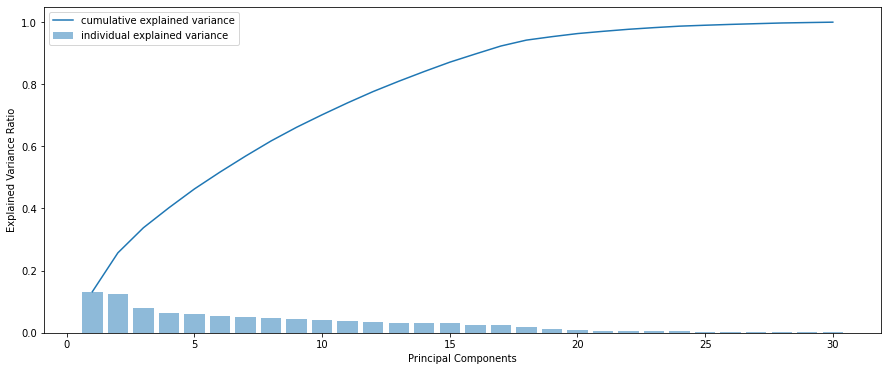

In [29]:
plt.figure(figsize=(15,6))
plt.plot(range(1, 31), soma_acumulativa_p, 
         label='cumulative explained variance')
plt.bar(range(1, 31), componentes_principais_p, alpha=0.5, align='center', 
        label='individual explained variance')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.legend(loc='best')
plt.show()

O gráfico acima nos mostra como a explainded variance se estabiliza a medida que consideramos mais dimensões no PCA. Neste caso iremos considerar 11 dimensões, uma vez que elas juntas possuem um pouco mais de 74% de representatividade dos dados.

- Catplot para as categorias dos produtos

<Figure size 720x1440 with 0 Axes>

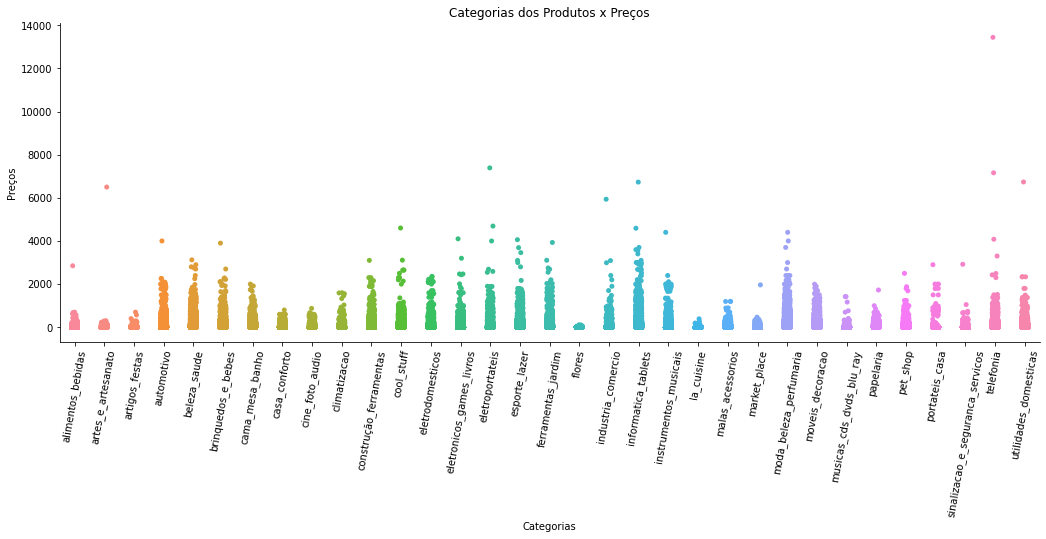

In [40]:
plt.figure(figsize=(10,20))
sns.catplot(data=df_category_precos,  height=5, aspect=3)
plt.title('Categorias dos Produtos x Preços')
plt.xlabel('Categorias')
plt.ylabel('Preços')
plt.xticks(rotation=80)
plt.show()

- PLots do resultado do PCA

In [31]:
# Considerando 11 dimensões
componentes_principais_p , soma_acumulativa_p, pca_p = pca_model(df_category_precos, 11)

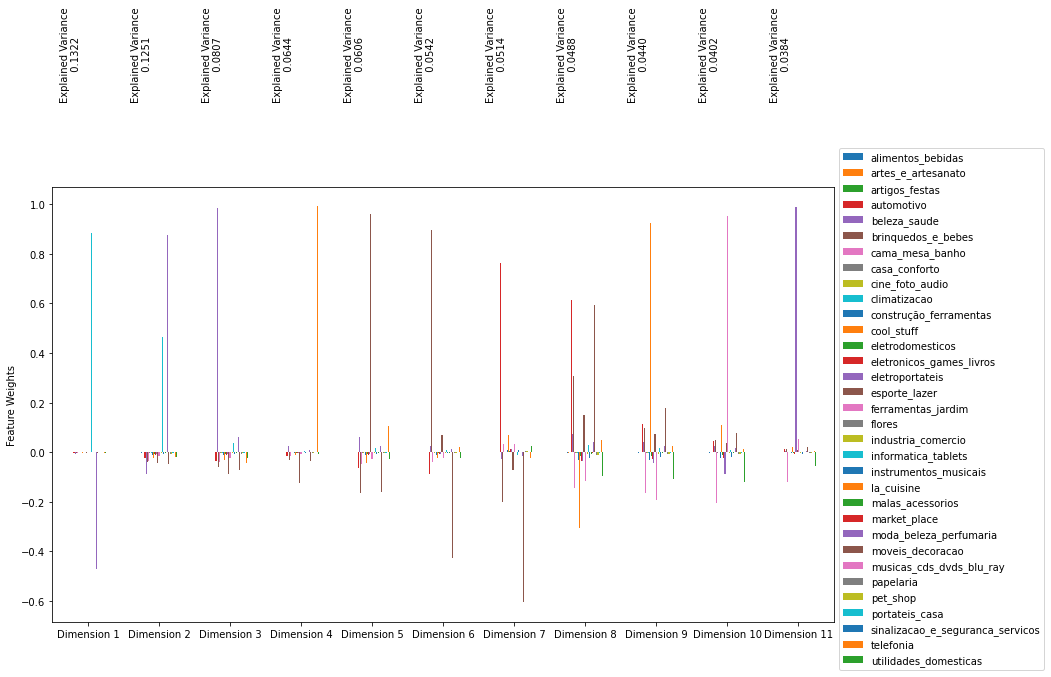

In [32]:
resultados_pca_p = vs.pca_results(df_category_precos, pca_p)

2) Dataframe df_category_flags

In [33]:
componentes_principais_f , soma_acumulativa_f, pca_f = pca_model(df_category_flags, 30)

In [34]:
# Verificando a variância
componentes_principais_f

array([0.11723583, 0.09938366, 0.09396423, 0.08806888, 0.08009181,
       0.07519782, 0.06712062, 0.05583983, 0.0488926 , 0.04481687,
       0.04125273, 0.03934654, 0.02723822, 0.02248288, 0.01951026,
       0.0128959 , 0.01105657, 0.01052706, 0.00770564, 0.00697174,
       0.0052069 , 0.00465175, 0.00461441, 0.0032998 , 0.00289701,
       0.00256686, 0.00196261, 0.00164905, 0.00128269, 0.00105933])

In [35]:
# Verificando a soma acumulativa da variância
soma_acumulativa_f

array([0.11723583, 0.21661949, 0.31058371, 0.39865259, 0.4787444 ,
       0.55394222, 0.62106284, 0.67690267, 0.72579527, 0.77061213,
       0.81186486, 0.8512114 , 0.87844962, 0.90093249, 0.92044275,
       0.93333866, 0.94439523, 0.95492229, 0.96262793, 0.96959968,
       0.97480657, 0.97945832, 0.98407273, 0.98737253, 0.99026954,
       0.9928364 , 0.99479901, 0.99644806, 0.99773076, 0.99879009])

- Gráfico Explained Variance Ratio x Principal Components

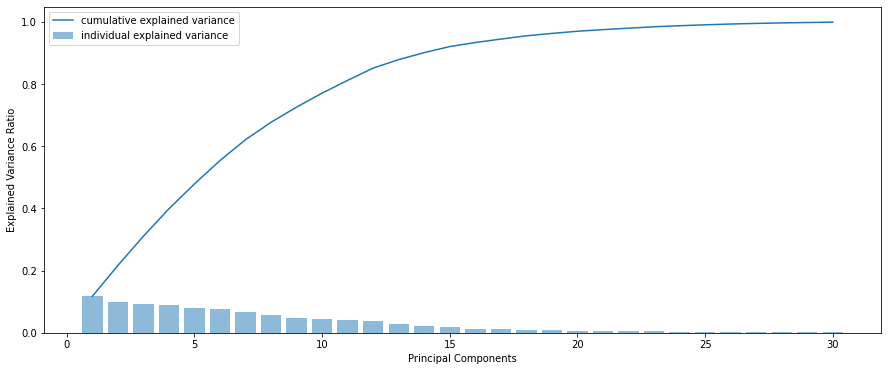

In [36]:
plt.figure(figsize=(15,6))
plt.plot(range(1, 31), soma_acumulativa_f, 
         label='cumulative explained variance')
plt.bar(range(1, 31), componentes_principais_f, alpha=0.5, align='center', 
        label='individual explained variance')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.legend(loc='best')
plt.show()

Ao usar apenas as flags (1 ou 0) vemos que as mesmas 11 dimensões tomadas anteriormente tem uma significância de 81% dos dados. Assim, usaremos essa quantidade para o gráfico do PCA.

- PLots do resultado do PCA

In [37]:
componentes_principais_f , soma_acumulativa_f, pca_f = pca_model(df_category_precos, 11)

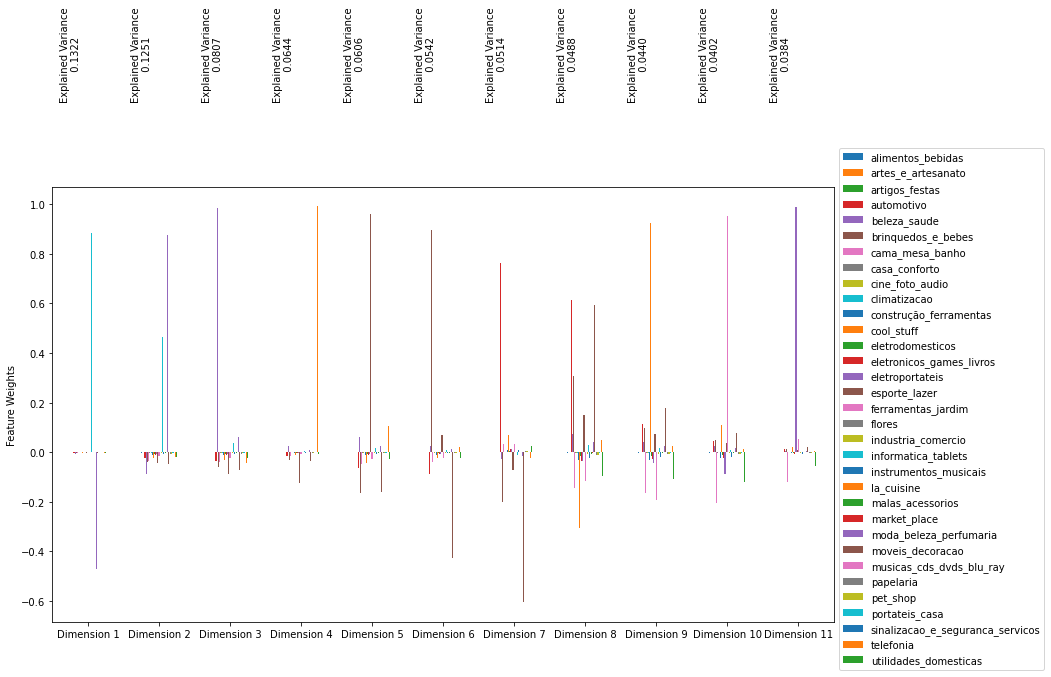

In [38]:
resultados_pca_f = vs.pca_results(df_category_precos, pca_f)